## Bioinformatics & Network Medicine

### Group 04 - Leukemia, Myelocytic, Acute C0023467
- Cruoglio Antonella
- Mascolo Davide
- Napoli Mario

In [ ]:
## Import Utils
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from random import seed, randint
import os 
from tqdm import tqdm
import time

### PPI and GDA data gathering and interactome reconstruction

In [ ]:
## Mount drive
drive.mount("/content/drive", force_remount = True)

## Change directory
%cd /content/drive/MyDrive/Secondo Anno/BI/Project

Mounted at /content/drive
/content/drive/MyDrive/Secondo Anno/BI/Project


In [ ]:
## Mount drive
drive.mount("/content/drive", force_remount = True)

## Change directory
%cd /content/drive/MyDrive/BI/Project

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1neT3DwF37GXQMfhu5yK3YjZJ67kzDRiK/BI/Project


#### PPI

Download PPI and GDA data gathering and interactome reconstruction.

In [ ]:
## Load data
data = pd.read_csv("/content/drive/MyDrive/BI/Data/BIOGRID-ORGANISM-Homo_sapiens-4.4.216.tab3.txt", sep = "\t")

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (1,2,18) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Filter out all non-human interactions, i.e., both “organism A” and “B” fields
must be = 9606 (Homo sapiens).

In [ ]:
## Filter data
data_filtered = data[(data["Organism ID Interactor A"] == 9606) & (data["Organism ID Interactor B"] == 9606)]

Keep only “physical” interactions (“Experimental System Type” = physical).

In [ ]:
## Filter data
data_filtered = data_filtered[data_filtered["Experimental System Type"] == "physical"]

Purge out redundant and self loops.

In [ ]:
## Filter data
data_filtered = data_filtered[data_filtered["Official Symbol Interactor A"] != data_filtered["Official Symbol Interactor B"]]

In [ ]:
## Shape
data_filtered.shape

(1023564, 37)

#### Create PPI network

At this point we used the PPi to build the network.

In [ ]:
## Filter data
data_filtered = data_filtered.rename(columns = {"Official Symbol Interactor A": "Gene1", "Official Symbol Interactor B": "Gene2"})

In [ ]:
## Create the graph
ppi = nx.from_pandas_edgelist(data_filtered, source = "Gene1", target = "Gene2",
                              create_using = nx.Graph())
nx.info(ppi)

<ipython-input-9-2b44b699f01a>:4: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  nx.info(ppi)


'Graph with 19724 nodes and 766017 edges'

In [ ]:
## Connected component of the network
conn_comp = list(nx.connected_components(ppi))
conn_comp_len = [len(c) for c in sorted(conn_comp, key=len, reverse=True)]
print("Number of connected components: ", conn_comp_len)

Number of connected components:  [19724]


In [ ]:
## Remove self loops
self_loop_edges = list(nx.selfloop_edges(ppi))
ppi.remove_edges_from(self_loop_edges)
nx.info(ppi)

<ipython-input-11-a5eb8d18c3d1>:4: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  nx.info(ppi)


'Graph with 19724 nodes and 766017 edges'

#### GDA

Import Gene Disease Association from DisGeNET.

In [ ]:
## Import data
gda_data = pd.read_csv("/content/drive/MyDrive/BI/Data/C0023467_disease_gda_summary.tsv", sep = "\t")

In [ ]:
## Check
gda_data.shape

(3111, 18)

#### Compute the disease LCC and its basic network measures

Check for the presence of disease genes in the interactome.

In [ ]:
## PPI genes
ppi_genes = set(ppi.nodes())

In [ ]:
## Common genes
common_genes = set.intersection(ppi_genes, gda_data['Gene'].tolist())

In [ ]:
## Extract subgraph
dis_net = ppi.subgraph(common_genes)

In [ ]:
## Extract connected component
conn_comp = list(nx.connected_components(dis_net))
conn_comp_len = [len(c) for c in sorted(conn_comp, key=len, reverse=True)]
print("Number of connected components: ", conn_comp_len)

Number of connected components:  [2570, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [ ]:
## Create the network of the LCC
dis_net_LCC = dis_net.subgraph(max(conn_comp, key = len)).copy()

In [ ]:
## Remove self loops
self_loop_edges = list(nx.selfloop_edges(dis_net_LCC))
dis_net_LCC.remove_edges_from(self_loop_edges)
nx.info(dis_net_LCC)

<ipython-input-34-74f1d14554fc>:4: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  nx.info(dis_net_LCC)


'Graph with 2570 nodes and 40854 edges'

Summary of GDA data:

In [ ]:
## Extract info
DiseaseName = gda_data['Disease'][0]
Disease_id = gda_data['Disease_id'][0]
DiseaseMeSH = "C04"
NumAssGenes = gda_data.shape[0]
NumGenesPPI = len(common_genes)
LCCsize = len(conn_comp[0])

In [ ]:
## Check
pd.DataFrame({'Disease Name': [DiseaseName], 'UMLS disease ID': [Disease_id], "MeSH disease class": DiseaseMeSH,
              'Number of associated genes' : NumAssGenes, 'Number of genes present in the interactome' : NumGenesPPI, 'LCC size of the disease interactome' : LCCsize})

,Disease Name,UMLS disease ID,MeSH disease class,Number of associated genes,Number of genes present in the interactome,LCC size of the disease interactome
0,"Leukemia, Myelocytic, Acute",C0023467,C04,3111,2709,2570


#### Compute the following network metrics on the disease LCC:

In [ ]:
## Instantiate an empty dictonary
nodes = dis_net_LCC.nodes()
gen_measures = dict(nodes)

* Node Degree


In [ ]:
## Degree
degree = dis_net_LCC.degree()
degree = dict(degree)
sorted(degree.items(), key=lambda x: x[1], reverse = True)

[('MYC', 547),
 ('TP53', 481),
 ('ESR1', 453),
 ('NTRK1', 390),
 ('APP', 388),
 ('ESR2', 385),
 ('EP300', 376),
 ('BRD4', 343),
 ('HSP90AA1', 343),
 ('EGFR', 342),
 ('PARP1', 316),
 ('DDX58', 311),
 ('HNRNPH1', 303),
 ('XPO1', 302),
 ('BRCA1', 284),
 ('NR2C2', 277),
 ('AR', 274),
 ('HDAC1', 262),
 ('CTNNB1', 261),
 ('CDC42', 249),
 ('APEX1', 247),
 ('WDR5', 239),
 ('SQSTM1', 239),
 ('KRAS', 238),
 ('NPM1', 236),
 ('FZR1', 235),
 ('HDAC6', 234),
 ('EGLN3', 234),
 ('MYCN', 233),
 ('HDAC2', 227),
 ('FBXW7', 223),
 ('PRMT1', 220),
 ('HNRNPA1', 220),
 ('PML', 213),
 ('RAC1', 212),
 ('ACTB', 211),
 ('YWHAE', 210),
 ('CREBBP', 209),
 ('YWHAZ', 209),
 ('CDK2', 209),
 ('HSP90AB1', 207),
 ('MDM2', 206),
 ('NR3C1', 204),
 ('RBM39', 203),
 ('CHD4', 203),
 ('AKT1', 199),
 ('EZH2', 198),
 ('UBE2I', 198),
 ('HSPA4', 196),
 ('GSK3B', 195),
 ('PRKDC', 193),
 ('LYN', 185),
 ('AGR2', 184),
 ('FANCD2', 184),
 ('HNRNPK', 184),
 ('FUS', 183),
 ('HSPB1', 180),
 ('EWSR1', 179),
 ('CDK9', 176),
 ('CAV1', 175),

* Betweenness centrality

In [ ]:
## Betweenness centrality
between = nx.betweenness_centrality(dis_net_LCC)
sorted(between.items(), key=lambda x: x[1], reverse = True)

[('APP', 0.05630280156843207),
 ('DDX58', 0.044013164277127356),
 ('MYC', 0.043529841349000335),
 ('TP53', 0.04034917678580847),
 ('HNRNPH1', 0.03167473220192645),
 ('ESR1', 0.02838963687253409),
 ('ESR2', 0.025017134613182727),
 ('EGFR', 0.024980786069638834),
 ('HSP90AA1', 0.02338650979110978),
 ('EP300', 0.020805441893968452),
 ('NTRK1', 0.020128992674857592),
 ('APEX1', 0.019146920327936794),
 ('XPO1', 0.01718815804623907),
 ('SQSTM1', 0.012692363628301624),
 ('BRD4', 0.012539401630790432),
 ('PARP1', 0.012481110250632489),
 ('CDC42', 0.012419161252249964),
 ('KRAS', 0.012379412092274129),
 ('ACTB', 0.012142036249590453),
 ('BRCA1', 0.010532345473157007),
 ('NR3C1', 0.010288193316359337),
 ('EGLN3', 0.009821407415085446),
 ('CREBBP', 0.009806032851611439),
 ('CTNNB1', 0.009389166213704449),
 ('HDAC6', 0.009014926062328375),
 ('RAC1', 0.008993858081124786),
 ('AR', 0.008980264799304938),
 ('FZR1', 0.008729299564287628),
 ('TRAF2', 0.008623751371049326),
 ('GSK3B', 0.0086224078352887

* Eigenvector Centrality

In [ ]:
## Eigenvector Centrality
eigenvec = nx.eigenvector_centrality(dis_net_LCC)
sorted(eigenvec.items(), key=lambda x: x[1], reverse = True)

[('MYC', 0.1568129245167714),
 ('TP53', 0.1363344639277951),
 ('ESR1', 0.13259580919408387),
 ('BRD4', 0.11874453686801148),
 ('EP300', 0.1150154757500738),
 ('NTRK1', 0.11046389947619234),
 ('PARP1', 0.10401677117083907),
 ('HSP90AA1', 0.10177830692868903),
 ('BRCA1', 0.0986518806002242),
 ('NPM1', 0.09712177902575202),
 ('CTNNB1', 0.0964326553827929),
 ('ESR2', 0.09552591839659035),
 ('AR', 0.09175663684459731),
 ('WDR5', 0.09103168468484545),
 ('NR2C2', 0.08988385050090633),
 ('EGFR', 0.08907112981684595),
 ('HDAC1', 0.0874364744406295),
 ('PRMT1', 0.08570319881914171),
 ('XPO1', 0.08558129687349447),
 ('RBM39', 0.08492888538920926),
 ('CHD4', 0.08424051162251259),
 ('MYCN', 0.08420278076260804),
 ('HDAC2', 0.08402755702499616),
 ('HNRNPA1', 0.08293084663170343),
 ('HDAC6', 0.08234472959821475),
 ('FZR1', 0.07967951670479448),
 ('HSP90AB1', 0.07826381228103779),
 ('PRPF8', 0.07744721893374665),
 ('FBXW7', 0.07709719215388273),
 ('PRKDC', 0.07634695535250739),
 ('FUS', 0.075709423449

* Closeness Centrality

In [ ]:
## Closeness Centrality
closeness = nx.closeness_centrality(dis_net_LCC)
sorted(closeness.items(), key=lambda x: x[1], reverse = True)

[('MYC', 0.5316639072847682),
 ('TP53', 0.5180479935470861),
 ('ESR1', 0.51359456217513),
 ('ESR2', 0.5014639859457349),
 ('APP', 0.5006821282401092),
 ('EGFR', 0.4998054474708171),
 ('HSP90AA1', 0.4982544608223429),
 ('NTRK1', 0.4968091278282731),
 ('EP300', 0.4967130703789637),
 ('BRD4', 0.49101681957186544),
 ('CTNNB1', 0.4894265574395123),
 ('XPO1', 0.4870142180094787),
 ('PARP1', 0.4870142180094787),
 ('HNRNPH1', 0.4855414855414855),
 ('SQSTM1', 0.4848084544253633),
 ('NPM1', 0.48426013195098966),
 ('HDAC6', 0.48253193087903834),
 ('AR', 0.4808160209620064),
 ('BRCA1', 0.4808160209620064),
 ('AKT1', 0.4806361085126286),
 ('APEX1', 0.48054620276842497),
 ('MDM2', 0.4794699514744308),
 ('ACTB', 0.4792016414847976),
 ('DDX58', 0.47911227154047),
 ('PML', 0.4783985102420857),
 ('YWHAZ', 0.4782204020848846),
 ('WDR5', 0.4777757113632137),
 ('HNRNPA1', 0.47706592386258123),
 ('HSPA4', 0.476446587537092),
 ('CDC42', 0.47635824216577044),
 ('HSP90AB1', 0.4759170062986291),
 ('HDAC1', 0.47

* Ratio Betweenness/Node Degree

In [ ]:
## Ratio Betweenness / Node Degree
bd_ratio = [between[k]/degree[k] for k,v in between.items()]
bd_ratio = dict(zip(between.keys(), bd_ratio))
sorted(bd_ratio.items(), key=lambda x: x[1], reverse = True)

[('GHRHR', 0.0003892565200467108),
 ('CALCA', 0.0003892565200467108),
 ('IL17A', 0.0002611363652010281),
 ('IL23R', 0.0002595043466978072),
 ('KIR2DS2', 0.0001992150241305659),
 ('FABP4', 0.00019777456800502537),
 ('CORT', 0.00019532596785168605),
 ('KCNJ5', 0.00019488700357284187),
 ('KITLG', 0.00019488330226899743),
 ('LTA', 0.00016401175251481778),
 ('CCL19', 0.00015703013460399462),
 ('CD200R1', 0.000156541148207916),
 ('CXCL8', 0.00014664345208378286),
 ('APP', 0.00014511031332070122),
 ('DDX58', 0.00014152142854381787),
 ('SETBP1', 0.00013810249354049745),
 ('CD96', 0.0001320757358576639),
 ('CD48', 0.00013162815055583956),
 ('GGT1', 0.00013076378659197964),
 ('DCAF6', 0.00013073188259077329),
 ('EFNA5', 0.00012078047218177125),
 ('PDCD1LG2', 0.0001138776886832354),
 ('SFRP2', 0.00011230625721746443),
 ('TRIM34', 0.00011217797366723312),
 ('GNMT', 0.00011148746148463748),
 ('PLXNA2', 0.000108322473299519),
 ('HNRNPH1', 0.00010453706997335463),
 ('NEAT1', 0.00010166218025842391),


In [ ]:
## Save metrics
for gene in gen_measures:
    gen_measures[gene]['Degree'] = degree[gene]
    gen_measures[gene]['Betweenness'] = between[gene]
    gen_measures[gene]['Eigenvector'] = eigenvec[gene]
    gen_measures[gene]['Closeness'] = closeness[gene]
    gen_measures[gene]['Ratio Betweennes:Degree'] = bd_ratio[gene]

In [ ]:
## Check
gen_measures

{'SAMHD1': {'Degree': 40,
  'Betweenness': 0.00016692320053935465,
  'Eigenvector': 0.018408024249423654,
  'Closeness': 0.41355441081777206,
  'Ratio Betweennes:Degree': 4.173080013483866e-06},
 'RAD51B': {'Degree': 9,
  'Betweenness': 2.5741037634563302e-05,
  'Eigenvector': 0.0020365651306819255,
  'Closeness': 0.34153150757777184,
  'Ratio Betweennes:Degree': 2.860115292729256e-06},
 'INVS': {'Degree': 4,
  'Betweenness': 2.8402657210082757e-06,
  'Eigenvector': 0.0011572435212420188,
  'Closeness': 0.3346795205836373,
  'Ratio Betweennes:Degree': 7.100664302520689e-07},
 'TOP2A': {'Degree': 100,
  'Betweenness': 0.0016240007395710355,
  'Eigenvector': 0.047589727091874236,
  'Closeness': 0.4406518010291595,
  'Ratio Betweennes:Degree': 1.6240007395710353e-05},
 'ARIH2': {'Degree': 63,
  'Betweenness': 0.0007414459397478744,
  'Eigenvector': 0.02725022367973886,
  'Closeness': 0.41535974130962006,
  'Ratio Betweennes:Degree': 1.176898317060118e-05},
 'EBP': {'Degree': 23,
  'Betwee

In [ ]:
## Summary
df_summary = pd.DataFrame.from_dict(gen_measures, orient = "index").sort_values("Ratio Betweennes:Degree", ascending = False)
df_summary.index.name = "Gene Name"
df_summary.reset_index(inplace = True)

In [ ]:
## Adding Rank
ranking = list(range(1, len(nodes) + 1))
df_summary.insert(loc = 0, column = "Ranking", value = ranking)

In [ ]:
## Check
df_summary = df_summary.reset_index(drop = True)
df_summary.head(50)

,Ranking,Gene Name,Degree,Betweenness,Eigenvector,Closeness,Ratio Betweennes:Degree
0,1,CALCA,2,0.000779,0.000042,0.265585,0.000389
1,2,GHRHR,2,0.000779,0.000195,0.293098,0.000389
2,3,IL17A,3,0.000783,0.000350,0.312416,0.000261
3,4,IL23R,3,0.000779,0.000978,0.329697,0.000260
4,5,KIR2DS2,4,0.000797,0.000238,0.303628,0.000199
5,6,FABP4,4,0.000791,0.001313,0.333593,0.000198
6,7,CORT,4,0.000781,0.000114,0.285921,0.000195
7,8,KCNJ5,4,0.000780,0.000414,0.312189,0.000195
8,9,KITLG,4,0.000780,0.000557,0.319012,0.000195
9,10,LTA,5,0.000820,0.000961,0.330801,0.000164


### Putative disease genes identification algorithms

In [ ]:
## Create seed genes txt
with open(r"seed_genes.txt", "w") as fp:
    fp.write("\n".join(str(item) for item in common_genes))

In [ ]:
## Create PPI txt
Gene1 = data_filtered["Gene1"]
Gene2 = data_filtered["Gene2"]
ppi_df = pd.DataFrame({"Gene1":Gene1, "Gene2":Gene2})
ppi_df.to_csv(r"PPI.txt", header = None, index = None, sep = ",")

At this step we applied three algorithms and evaluated their performances using the $K$-Fold Cross Validation with $K = 5$.

In [ ]:
## Create genes txt
with open(r"ppi_genes.txt", "w") as fp:
    fp.write("\n".join(str(item) for item in ppi.nodes))

In [ ]:
## Implement a function to make cross validation
def cross_validation(data, k, seed_genes):
    """
    Input:  data of PPI, number of folds, seed genes
    Output: splitted data saved in drive
    """
    ## Cycle
    for i in tqdm(range(k), desc = "Progress Bar"):
        ## Define cardinality of folders
        fold_min = np.array_split(range(0, len(seed_genes)), k)[i][0]
        fold_max = np.array_split(range(0, len(seed_genes)), k)[i][-1]

        ## Define the test seed genes
        seed_test = list(seed_genes)[fold_min:fold_max]
 
        ## Create test txt
        with open(f"seed_test_{i}.txt", "w") as fp:
            fp.write("\n".join(str(item) for item in seed_test))

        ## Define the train seed genes
        seed_train = set(seed_genes) - set(seed_test)

        ## Create train txt
        with open(f"seed_train_{i}.txt", "w") as fp:
            fp.write("\n".join(str(item) for item in seed_train))    

In [ ]:
## Create a function to compute DIAMOnd, DiaBLE and Dififfusion Based algorithm
def algorithm(name, k, top_k, t = None):
    """
    Input:  type of algorithm, number of folds, number of putative genes, arbitraty time of diffusion
    Output: Different metrics to evaluate the performances
    """
    ## Define metrics
    precision = []
    recall    = []
    f1_score  = []

    ## Cycle
    for i in tqdm(range(k), desc = "Progress Bar"):

        ## import test seed genes
        seed_test  = pd.read_csv(f"seed_test_{i}.txt", sep = "\t")
        seed_test  = set(seed_test.iloc[:,0].tolist())

        ## Select the algorithm and train
        if name == "DIAMOnD":
            os.system(f"python3  DIAMOnD_DiaBLE/DIAMOnD.py PPI.txt seed_train_{i}.txt " + str(top_k))

            ## Evaluate
            list_genes = pd.read_csv(f"first_{top_k}_added_nodes_weight_1.txt", sep = "\t")
            ## Comparison with test
            ## Select the top k genes
            cv_nodes = list_genes[name + "_node"].tolist()
            cv_nodes = set(cv_nodes)

            ## Compute Precision, Recall and F1-Score
            ## True positive (present in both)
            TP = len(cv_nodes.intersection(seed_test))
            ## True Negative (not present in both)
            TN = len(cv_nodes ^ set(seed_test))
            ## False Positive (present in prediction but not in test set)
            FP = len(list(cv_nodes.difference(seed_test)))
            ## False Negative (present in the test set but not in the prediction)
            FN = len(list(set(seed_test).difference(cv_nodes)))

            ## Metrics
            precision.append(TP/(TP+FP+10e-10))
            recall.append(TP/(TP+FN+10e-10))
            pr_values = TP/(TP+FP)
            rc_values = TP/(TP+FN)
            f1_score.append((2*pr_values*rc_values)/(pr_values+rc_values+10e-10))
        
        ## Select the algorithm and train
        if name == "DiaBLE":
            os.system(f"python3  DIAMOnD_DiaBLE/DiaBLE.py PPI.txt seed_train_{i}.txt " + str(top_k))

            ## Evaluate
            list_genes = pd.read_csv(f"first_{top_k}_added_nodes_weight_1.txt", sep = "\t")
            cv_nodes = list_genes["DIAMOnD_node"].tolist()
            cv_nodes = set(cv_nodes)

            ## Compute Precision, Recall and F1-Score
            TP = len(cv_nodes.intersection(seed_test))
            TN = len(cv_nodes ^ set(seed_test))
            FP = len(list(cv_nodes.difference(seed_test)))
            FN = len(list(set(seed_test).difference(cv_nodes)))

            ## Metrics
            precision.append(TP/(TP+FP+10e-10))
            recall.append(TP/(TP+FN+10e-10))
            pr_values = TP/(TP+FP)
            rc_values = TP/(TP+FN)
            f1_score.append((2*pr_values*rc_values)/(pr_values+rc_values+10e-10))

        ## Select the algorithm and train
        if name == "Diffusion":
            ## results of diffusion algorithm for a specific train set and time
            list_genes = pd.read_csv(f"diffusion_data/diff_{t}_{i}.csv") 
            ## selecting only the first k elements
            list_genes = list_genes.sort_values(by = "diffusion_output_rank")[:top_k]
            ## Comparison with test
            ## Select the top k genes
            cv_nodes = list_genes["name"].tolist()
            cv_nodes = set(cv_nodes)

            ## Compute Precision, Recall and F1-Score
            TP = len(cv_nodes.intersection(seed_test))
            TN = len(cv_nodes ^ set(seed_test))
            FP = len(list(cv_nodes.difference(seed_test)))
            FN = len(list(set(seed_test).difference(cv_nodes)))

            ## Metrics
            precision.append(TP/(TP+FP+10e-10))
            recall.append(TP/(TP+FN+10e-10))
            pr_values = TP/(TP+FP)
            rc_values = TP/(TP+FN)
            f1_score.append((2*pr_values*rc_values)/(pr_values+rc_values+10e-10))

    ## Return
    return {"Avg_Precision": np.mean(precision),
            "Avg_Recall": np.mean(recall),
            "Avg_F1-Score": np.mean(f1_score),
            "Sd_Precision": np.std(precision),
            "Sd_Recall": np.std(recall),
            "Sd_F1-Score": np.std(f1_score)} 

##### Algorithm run

In [ ]:
## Number of disease's genes
n = len(common_genes)

In [ ]:
## Apply Cross Validation
cross_validation(ppi, 5, common_genes)

Progress Bar: 100%|██████████| 5/5 [00:00<00:00, 87.31it/s]


In [ ]:
## Apply DIAMOnD
diamond_50  = algorithm("DIAMOnD", 5, 50)
diamond_n   = algorithm("DIAMOnD", 5, n)
diamond_n2  = algorithm("DIAMOnD", 5, int(n/2))
diamond_n4  = algorithm("DIAMOnD", 5, int(n/4))
diamond_n10 = algorithm("DIAMOnD", 5, int(n/10))

Progress Bar: 100%|██████████| 5/5 [30:06<00:00, 361.35s/it]


In [ ]:
## Collect the performances in a table
raw_data = {"Avg_Precision": [diamond_50["Avg_Precision"], diamond_n["Avg_Precision"],
                              diamond_n2["Avg_Precision"], diamond_n4["Avg_Precision"], diamond_n10["Avg_Precision"]],
            "Avg_Recall": [diamond_50["Avg_Recall"], diamond_n["Avg_Recall"],
                              diamond_n2["Avg_Recall"], diamond_n4["Avg_Recall"], diamond_n10["Avg_Recall"]],
            "Avg_F1_Score": [diamond_50["Avg_F1-Score"], diamond_n["Avg_F1-Score"],
                              diamond_n2["Avg_F1-Score"], diamond_n4["Avg_F1-Score"], diamond_n10["Avg_F1-Score"]],
            "Sd_Precision": [diamond_50["Sd_Precision"], diamond_n["Sd_Precision"],
                              diamond_n2["Sd_Precision"], diamond_n4["Sd_Precision"], diamond_n10["Sd_Precision"]],
            "Sd_Recall": [diamond_50["Sd_Recall"], diamond_n["Sd_Recall"],
                              diamond_n2["Sd_Recall"], diamond_n4["Sd_Recall"], diamond_n10["Sd_Recall"]],
            "Sd_F1_Score": [diamond_50["Sd_F1-Score"], diamond_n["Sd_F1-Score"],
                              diamond_n2["Sd_F1-Score"], diamond_n4["Sd_F1-Score"], diamond_n10["Sd_F1-Score"]]}

## Rename columns
df_diamond = pd.DataFrame(raw_data)
df_diamond = df_diamond.rename(index = {0:"Diamond_50", 1:"Diamond_n", 2:"Diamond_N/2", 3:"Diamond_N/4", 4:"Diamond_N/10"})

In [ ]:
## Check
df_diamond

,Avg_Precision,Avg_Recall,Avg_F1_Score,Sd_Precision,Sd_Recall,Sd_F1_Score
Diamond_50,0.284000,0.026306,0.048152,0.029394,0.002720,0.004980
Diamond_n,0.057660,0.289366,0.096159,0.004370,0.021923,0.007288
Diamond_N/2,0.064993,0.163025,0.092935,0.006737,0.016913,0.009635
Diamond_N/4,0.072674,0.091144,0.080868,0.009028,0.011313,0.010042
Diamond_N/10,0.117778,0.058910,0.078537,0.017435,0.008714,0.011620


In [ ]:
## Save the table
df_diamond.to_csv("/content/drive/MyDrive/Secondo Anno/BI/Project/Diamond_Performances.csv")

In order to run the Diable algorithm we need to manage the runtime of colab to avoid its "explosion". So, we run the algorithm for the first two cases and we save the intermediate results. At this point we need to restart the runtime and make the same operation for the remaining parts. In conclusione we can look the final table.

*Don't run the following chunks, check only the final table performance.*

In [ ]:
## Apply DiaBLE
diable_50  = algorithm(name = "DiaBLE", k = 5, top_k = 50)
diable_n  = algorithm(name = "DiaBLE", k = 5, top_k = n)

In [ ]:
## Collect the performances in a table
raw_data_diable_1 = {"Avg_Precision": [diable_50["Avg_Precision"], diable_n["Avg_Precision"]],
                     "Avg_Recall": [diable_50["Avg_Recall"], diable_n["Avg_Recall"]],
                     "Avg_F1_Score": [diable_50["Avg_F1-Score"], diable_n["Avg_F1-Score"]],
                     "Sd_Precision": [diable_50["Sd_Precision"], diable_n["Sd_Precision"]],
                     "Sd_Recall": [diable_50["Sd_Recall"], diable_n["Sd_Recall"]],
                     "Sd_F1_Score": [diable_50["Sd_F1-Score"], diable_n["Sd_F1-Score"]]}

## Rename columns
df_diable_1 = pd.DataFrame(raw_data_diable_1)
df_diable_1 = df_diable_1.rename(index = {0:"Diable_50", 1:"Diable_n"})

In [ ]:
## Check
df_diable_1

,Avg_Precision,Avg_Recall,Avg_F1_Score,Sd_Precision,Sd_Recall,Sd_F1_Score
Diable_50,0.28400,0.026306,0.048152,0.029394,0.002720,0.004980
Diable_n,0.05766,0.289366,0.096159,0.004370,0.021923,0.007288


In [ ]:
## Save the table
df_diable_1.to_csv("/content/drive/MyDrive/Secondo Anno/BI/Project/Diable_Performances_1.csv")

Remember: restart the runtime and also the useful things in the first cells.

In [ ]:
## Apply DiaBLE pt.2
diable_n2  = algorithm("DiaBLE", 5, int(n/2))
diable_n4  = algorithm("DiaBLE", 5, int(n/4))
diable_n10 = algorithm("DiaBLE", 5, int(n/10))

Progress Bar: 100%|██████████| 5/5 [36:38<00:00, 439.76s/it]


In [ ]:
## Collect the performances in a table
raw_data_diable_2 = {"Avg_Precision": [diable_n2["Avg_Precision"], diable_n4["Avg_Precision"], diable_n10["Avg_Precision"]],
                     "Avg_Recall": [diable_n2["Avg_Recall"], diable_n4["Avg_Recall"], diable_n10["Avg_Recall"]],
                     "Avg_F1_Score": [diable_n2["Avg_F1-Score"], diable_n4["Avg_F1-Score"], diable_n10["Avg_F1-Score"]],
                     "Sd_Precision": [diable_n2["Sd_Precision"], diable_n4["Sd_Precision"], diable_n10["Sd_Precision"]],
                     "Sd_Recall": [diable_n2["Sd_Recall"], diable_n4["Sd_Recall"], diable_n10["Sd_Recall"]],
                     "Sd_F1_Score": [diable_n2["Sd_F1-Score"], diable_n4["Sd_F1-Score"], diable_n10["Sd_F1-Score"]]}

## Rename columns
df_diable_2 = pd.DataFrame(raw_data_diable_2)
df_diable_2 = df_diable_2.rename(index = {0:"Diable_n2", 1:"Diable_n4", 2:"Diable_n10"})

In [ ]:
## Save the table
df_diable_2.to_csv("/content/drive/MyDrive/Secondo Anno/BI/Project/Diable_Performances_2.csv")

In [ ]:
## Check
df_diable_2

,Avg_Precision,Avg_Recall,Avg_F1_Score,Sd_Precision,Sd_Recall,Sd_F1_Score
Diable_n2,0.064993,0.163025,0.092935,0.006737,0.016913,0.009635
Diable_n4,0.072674,0.091144,0.080868,0.009028,0.011313,0.010042
Diable_n10,0.117778,0.058910,0.078537,0.017435,0.008714,0.011620


At this point we can import the two different results and visualize them in a unique table.

In [ ]:
## Import 
url_1 = "/content/drive/MyDrive/Secondo Anno/BI/Project/Diable_Performances_1.csv"
url_2 = "/content/drive/MyDrive/Secondo Anno/BI/Project/Diable_Performances_2.csv"
df_1  = pd.read_csv(url_1)
df_2  = pd.read_csv(url_2)

## Join
df_diable = pd.concat([df_1, df_2])
## Remove index
blankIndex =[""] * len(df_diable)
df_diable.index = blankIndex
## Change name columns
df_diable.columns = ["Type", "Avg_precision", "Avg_Recall", "Avg_F1_Score", "Sd_Precision", "Sd_Recall", "Sd_F1_Score"]

## Save the table
df_diable.to_csv("/content/drive/MyDrive/Secondo Anno/BI/Project/Diable_Performances.csv")

## Check
df_diable

,Type,Avg_precision,Avg_Recall,Avg_F1_Score,Sd_Precision,Sd_Recall,Sd_F1_Score
,Diable_50,0.284000,0.026306,0.048152,0.029394,0.002720,0.004980
,Diable_n,0.057660,0.289366,0.096159,0.004370,0.021923,0.007288
,Diable_n2,0.064993,0.163025,0.092935,0.006737,0.016913,0.009635
,Diable_n4,0.072674,0.091144,0.080868,0.009028,0.011313,0.010042
,Diable_n10,0.117778,0.058910,0.078537,0.017435,0.008714,0.011620


#### Performance Evaluation

* DIAMOnD

In [ ]:
## Import Diamond results
diamond = pd.read_csv('/content/drive/MyDrive/BI/Project/Diamond_Performances.csv')

In [ ]:
## Rename columns
diamond.columns = ['0',  "Avg_Precision", "Avg_Recall", "Avg_F1-Score", "Sd_Precision", "Sd_Recall", "Sd_F1-Score"]

In [ ]:
## Check
diamond_50  = diamond.loc[0][1:].to_dict()
diamond_n   = diamond.loc[1][1:].to_dict()
diamond_n2  = diamond.loc[2][1:].to_dict()
diamond_n4  = diamond.loc[3][1:].to_dict()
diamond_n10 = diamond.loc[4][1:].to_dict()

* DiaBLE

In [ ]:
## Import performances
diable = pd.read_csv('/content/drive/MyDrive/BI/Project/Diable_Performances.csv')

In [ ]:
## Set columns name
diable.columns = ['0', '1', "Avg_Precision", "Avg_Recall", "Avg_F1-Score", "Sd_Precision", "Sd_Recall", "Sd_F1-Score"]

In [ ]:
## Transform to dict
diable_50  = diable.loc[0][2:].to_dict()
diable_n   = diable.loc[1][2:].to_dict()
diable_n2  = diable.loc[2][2:].to_dict()
diable_n4  = diable.loc[3][2:].to_dict()
diable_n10 = diable.loc[4][2:].to_dict()

* Diffusion, t = 0.002

In [ ]:
## Apply the Diffusion algorithm for different k and the same t
diffusion_50_t02 = algorithm(name = "Diffusion", k = 5, top_k = 50, t = "t02")
diffusion_n10_t02 = algorithm(name = "Diffusion", k = 5, top_k = int(n/10), t = "t02")
diffusion_n4_t02 = algorithm(name = "Diffusion", k = 5, top_k = int(n/4), t = "t02")
diffusion_n2_t02 = algorithm(name = "Diffusion", k = 5, top_k = int(n/2), t = "t02")
diffusion_n_t02 = algorithm(name = "Diffusion", k = 5, top_k = int(n), t = "t02")

Progress Bar: 100%|██████████| 5/5 [00:00<00:00,  6.01it/s]


* Diffusion, t = 0.005

In [ ]:
## Apply the Diffusion algorithm for different k and the same t
diffusion_50_t05 = algorithm(name = "Diffusion", k = 5, top_k = 50, t = "t05")
diffusion_n10_t05 = algorithm(name = "Diffusion", k = 5, top_k = int(n/10), t = "t05")
diffusion_n4_t05 = algorithm(name = "Diffusion", k = 5, top_k = int(n/4), t = "t05")
diffusion_n2_t05 = algorithm(name = "Diffusion", k = 5, top_k = int(n/2), t = "t05")
diffusion_n_t05 = algorithm(name = "Diffusion", k = 5, top_k = int(n), t = "t05")

Progress Bar: 100%|██████████| 5/5 [00:00<00:00, 20.74it/s]


* Diffusion, t = 0.01

In [ ]:
## Apply the Diffusion algorithm for different k and the same t
diffusion_50_t1 = algorithm(name = "Diffusion", k = 5, top_k = 50, t = "t1")
diffusion_n10_t1 = algorithm(name = "Diffusion", k = 5, top_k = int(n/10), t = "t1")
diffusion_n4_t1 = algorithm(name = "Diffusion", k = 5, top_k = int(n/4), t = "t1")
diffusion_n2_t1 = algorithm(name = "Diffusion", k = 5, top_k = int(n/2), t = "t1")
diffusion_n_t1 = algorithm(name = "Diffusion", k = 5, top_k = int(n), t = "t1")

Progress Bar: 100%|██████████| 5/5 [00:00<00:00, 20.58it/s]


Comparison:

In [ ]:
## Store all the performances in lists -- for plots
k50 = [diamond_50, diable_50, diffusion_50_t02, diffusion_50_t05, diffusion_50_t1]
precisions_50 = [algo['Avg_Precision'] for algo in k50]
recall_50 = [algo['Avg_Recall'] for algo in k50]
f1_score_50 = [algo['Avg_F1-Score'] for algo in k50]
P_error_50 = [2*algo['Sd_Precision'] for algo in k50]
R_error_50 = [2*algo['Sd_Recall'] for algo in k50]
F1_error_50 = [2*algo['Sd_F1-Score'] for algo in k50]


kn10 = [diamond_n10, diable_n10, diffusion_n10_t02, diffusion_n10_t05, diffusion_n10_t1]
precisions_n10 = [algo['Avg_Precision'] for algo in kn10]
recall_n10 = [algo['Avg_Recall'] for algo in kn10]
f1_score_n10 = [algo['Avg_F1-Score'] for algo in kn10]
P_error_n10 = [2*algo['Sd_Precision'] for algo in kn10]
R_error_n10 = [2*algo['Sd_Recall'] for algo in kn10]
F1_error_n10 = [2*algo['Sd_F1-Score'] for algo in kn10]


kn4 = [diamond_n4, diable_n4, diffusion_n4_t02, diffusion_n4_t05, diffusion_n4_t1]
precisions_n4 = [algo['Avg_Precision'] for algo in kn4]
recall_n4 = [algo['Avg_Recall'] for algo in kn4]
f1_score_n4 = [algo['Avg_F1-Score'] for algo in kn4]
P_error_n4 = [2*algo['Sd_Precision'] for algo in kn4]
R_error_n4 = [2*algo['Sd_Recall'] for algo in kn4]
F1_error_n4 = [2*algo['Sd_F1-Score'] for algo in kn4]


kn2 = [diamond_n2, diable_n2, diffusion_n2_t02, diffusion_n2_t05, diffusion_n2_t1]
precisions_n2 = [algo['Avg_Precision'] for algo in kn2]
recall_n2 = [algo['Avg_Recall'] for algo in kn2]
f1_score_n2 = [algo['Avg_F1-Score'] for algo in kn2]
P_error_n2 = [2*algo['Sd_Precision'] for algo in kn2]
R_error_n2 = [2*algo['Sd_Recall'] for algo in kn2]
F1_error_n2 = [2*algo['Sd_F1-Score'] for algo in kn2]


kn = [diamond_n, diable_n, diffusion_n_t02, diffusion_n_t05, diffusion_n_t1]
precisions_n = [algo['Avg_Precision'] for algo in kn]
recall_n = [algo['Avg_Recall'] for algo in kn]
f1_score_n = [algo['Avg_F1-Score'] for algo in kn]
R_error_n = [2*algo['Sd_Precision'] for algo in kn]
P_error_n = [2*algo['Sd_Recall'] for algo in kn]
F1_error_n = [2*algo['Sd_F1-Score'] for algo in kn]

In [ ]:
names = ['DIAMOnD', 'DiaBLE', 'Diffusion\n(t=0.002)', 'Diffusion\n(t=0.005)', 'Diffusion\n(t=0.01)']

## Implement a function for the plot
def plot_performances(names, precisions, recalls, f1_scores, precisions_sd, recalls_sd, f1_scores_sd, k):
    plt.figure(figsize = (20, 4))
    plt.subplot(131)
    plt.errorbar(names, precisions,
                yerr = precisions_sd,
                fmt ='o', elinewidth=3, markersize = 7)
    plt.title("Precision")

    plt.subplot(132)
    plt.errorbar(names, recalls,
                yerr = recalls_sd,
                fmt ='o', elinewidth=3, markersize = 7)
    plt.title("Recall")


    plt.subplot(133)
    plt.errorbar(names, f1_scores,
                yerr = f1_scores_sd,
                fmt ='o', elinewidth=3, markersize = 7)
    plt.title("F1-Score")
    plt.suptitle(f"Performance with k = {k}", size = 15,  y=1.05)
    plt.show()

K = 50

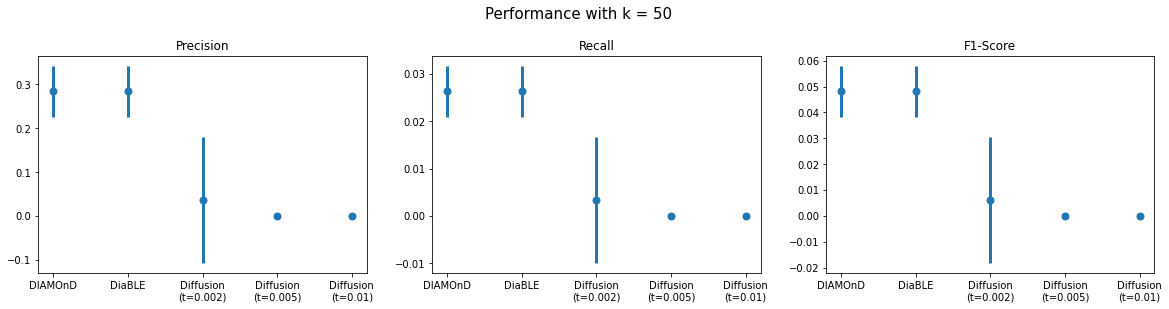

In [ ]:
## Performances for k = 50
plot_performances(names, precisions_50, recall_50, f1_score_50, P_error_50, R_error_50, F1_error_50, "50")

K = $\frac{n}{10}$ (270)

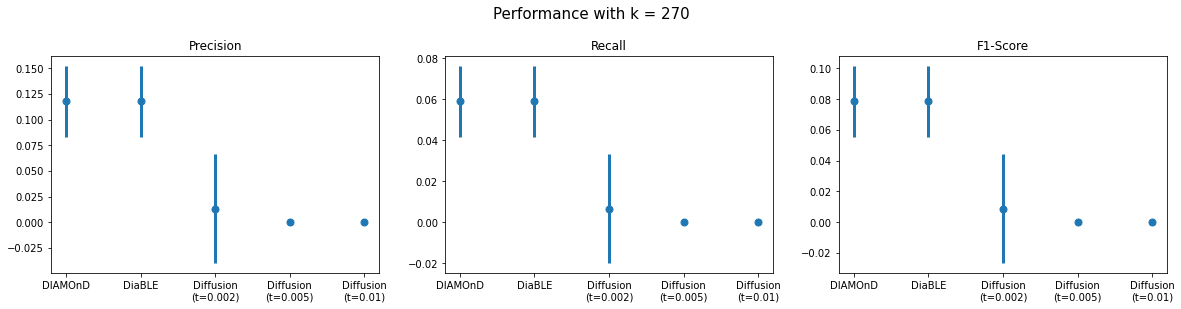

In [ ]:
## Performances for k = 270
plot_performances(names, precisions_n10, recall_n10, f1_score_n10, P_error_n10, R_error_n10, F1_error_n10, "270")

K = $\frac{n}{4}$ (677)

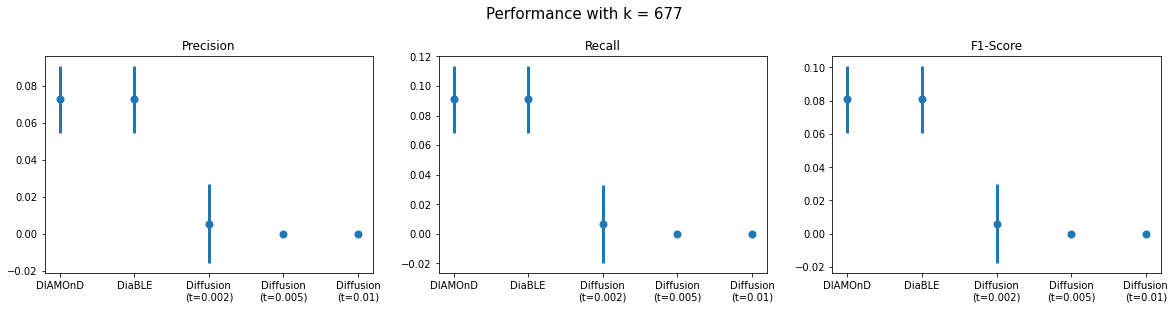

In [ ]:
## Performances for k = 677
plot_performances(names, precisions_n4, recall_n4, f1_score_n4, P_error_n4, R_error_n4, F1_error_n4, "677")

K = $\frac{n}{2}$ (1354)

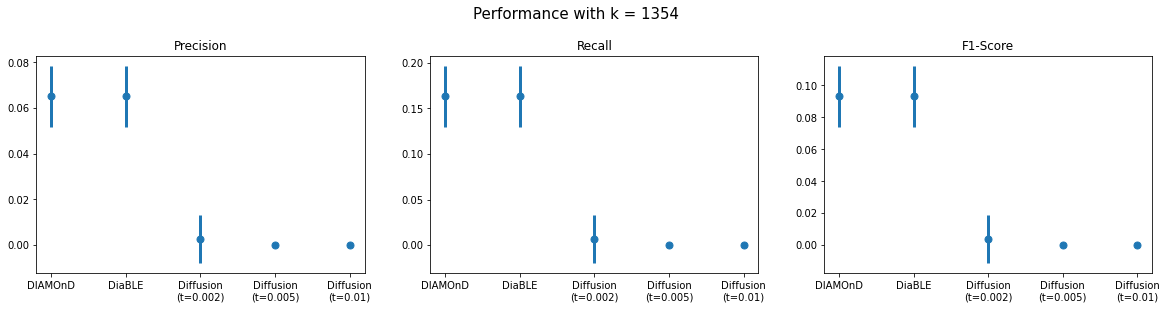

In [ ]:
## Performances for k = 1354
plot_performances(names, precisions_n2, recall_n2, f1_score_n2, P_error_n2, R_error_n2, F1_error_n2, "1354")

K = $n$ (2709)

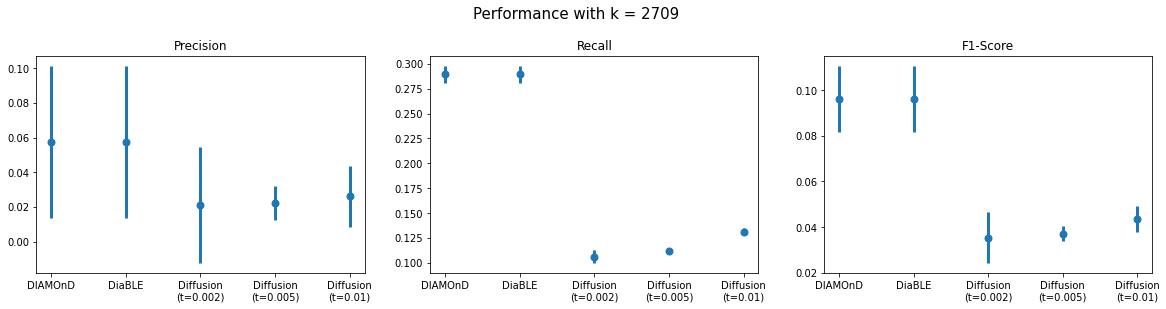

In [ ]:
## Performances for k = 2709
plot_performances(names, precisions_n, recall_n, f1_score_n, P_error_n, R_error_n, F1_error_n, "2709")

It seems that the performances of DIAMOnD and DiaBLE are better than the ones of the Diffusion Algorithm with different values of t.

According to the paper 
[Connectivity Significance for Disease Gene
Prioritization in an Expanding Universe](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8821247&casa_token=L-9_rBpCIJQAAAAA:IIFAd00UggE18Aqul8XLeg13paF-yeLWYIDpPYwsmfGYW-mJe6vcnYWQniIRnD2xLqA5-7Shups&tag=1) —the DiaBLE algorithm provides more biological meaningful results compared to DIAMOnD. For this reason, even if the two methods have quite the same performance, we decide to use DiaBLE.

### Best algorithm choice and putative disease gene identification

▪ select the best performing algorithm and apply the process to predict new putative disease genes using all known GDAs as seed genes

In [ ]:
## Select the best algorithm
os.system(f"python3  DIAMOnD_DiaBLE/DiaBLE.py PPI.txt seed_genes.txt 200")

0

▪	obtain a list of putative disease genes

In [ ]:
list_genes = pd.read_csv(f"first_200_added_nodes_weight_1.txt", sep = "\t")

## Select the top k genes
cv_nodes = list_genes["DIAMOnD_node"].tolist()
cv_nodes

['SP1',
 'XRCC6',
 'SFPQ',
 'NONO',
 'CIC',
 'KAT2B',
 'NCOA3',
 'XRCC5',
 'DDX3X',
 'GRB2',
 'HSPA8',
 'SHC1',
 'CSNK2A1',
 'CTBP1',
 'DDB1',
 'USP7',
 'SMAD2',
 'RBM14',
 'MATR3',
 'HNRNPM',
 'DDX5',
 'RPA1',
 'HNRNPA2B1',
 'MAP2K3',
 'TRIM28',
 'SMARCC2',
 'VCP',
 'HDAC5',
 'RUVBL1',
 'CAD',
 'YAP1',
 'HSPA1A',
 'EEF1D',
 'KIAA1429',
 'NCOR2',
 'CDC37',
 'CHUK',
 'PIAS1',
 'PTK2',
 'EEF2',
 'JUP',
 'HSPA5',
 'MAPT',
 'HNRNPF',
 'PPP1CA',
 'SYNCRIP',
 'RPA2',
 'MSN',
 'HIST1H3A',
 'UHRF2',
 'EED',
 'HCFC1',
 'NCOA6',
 'HNRNPA3',
 'DDX17',
 'CHD3',
 'CCAR2',
 'SUMO2',
 'TUBB',
 'MTA2',
 'HMGA1',
 'NEDD4',
 'ARID1A',
 'HNRNPR',
 'HIST3H3',
 'EPRS',
 'H2AFX',
 'DHX9',
 'CUL1',
 'GNB2L1',
 'PCBP1',
 'TARDBP',
 'HNRNPA0',
 'HNRNPD',
 'VHL',
 'HNRNPH3',
 'BIRC3',
 'PUF60',
 'YBX1',
 'HNRNPU',
 'EFTUD2',
 'RAN',
 'BTF3',
 'RANBP2',
 'HIST1H4A',
 'SNRPD1',
 'DDX1',
 'RPA3',
 'IARS',
 'C16orf72',
 'PCBP2',
 'BRD7',
 'KPNA2',
 'MCM2',
 'IKBKB',
 'UBC',
 'ATP5A1',
 'BAP1',
 'YWHAQ',
 'IQGAP1',


In [ ]:
## Check
list_genes

,#rank,DIAMOnD_node,p_hyper
0,1,SP1,4.705772e-44
1,2,XRCC6,3.022184e-29
2,3,SFPQ,2.553413e-28
3,4,NONO,1.708504e-27
4,5,CIC,4.273231e-27
...,...,...,...
195,196,HIST1H2BB,2.005226e-34
196,197,RPL12,2.973966e-34
197,198,HSPH1,1.587938e-33
198,199,SART1,8.135409e-34


At this point, perform the enrichment analysis (via EnrichR: GO BP, MF, CC, and KEGG pathways) over the first 200 putative disease genes 

### Drug Repurposing

Select the first 20 putative disease genes in the ranking obtained at point 4.

In [ ]:
first20 = cv_nodes[:20]
## First 20 putative disease genes
with open(r"20_putative_genes.txt", "w") as fp:
    fp.write("\n".join(str(item) for item in first20))

Use DGIdb (www.dgidb.org) to associate such 20 genes to drugs (access the db manually or via API or using the interaction dataset)

In [ ]:
## Import drug associated with the first 20 genes
drugs = pd.read_csv("dgidb_export_2023-01-04.tsv", sep = "\t")

In [ ]:
## Check
drugs.head()

,search_term,match_term,match_type,gene,drug,interaction_types,sources,pmids
0,SP1,SP1,Definite,SP1,METFORMIN,NaN,PharmGKB,24853734|29352482
1,SP1,SP1,Definite,SP1,TERAMEPROCOL,NaN,TTD,NaN
2,CIC,CIC,Definite,CIC,VEMURAFENIB,NaN,CIViC,28178529
3,CIC,CIC,Definite,CIC,SELUMETINIB,NaN,CIViC,28178529
4,CIC,CIC,Definite,CIC,TRAMETINIB,NaN,CIViC,28178529


Compile a ranking of drugs, starting from the one associated with the most of the above 20 genes down

In [ ]:
## Count number of genes associated to each drug
drugs.groupby(["drug"])['gene'].count().sort_values(ascending = False)

drug
BLEOMYCIN                           2
TRETINOIN                           2
THALIDOMIDE                         2
CISPLATIN                           2
IRINOTECAN HYDROCHLORIDE HYDRATE    1
                                   ..
COCAINE                             1
CURCUMIN                            1
CYC-116                             1
CYTARABINE                          1
VEMURAFENIB                         1
Name: gene, Length: 72, dtype: int64

Take the first three drugs and check on https://clinicaltrials.gov if there are clinical trials using each of the drug (search field: “other terms”) for the disease of interest (search field: “condition or disease”) and note the number of clinical trials.

* 0 studies for BLEOMYCIN
* 57 studies for TRETINOIN
* 1 study for THALIDOMIDE
* 0 studies for CISPLATIN

### OPTIONAL TASK Putative disease genes identification

In [ ]:
## Import PPI
ppi = pd.read_csv("PPI.txt", header = None)

In [ ]:
## Select columns
ppi.columns = ["Gene1", "Gene2"]

In [ ]:
## Create network
ppi = nx.from_pandas_edgelist(ppi, source = "Gene1", target = "Gene2",
                              create_using = nx.Graph())

In [ ]:
## Info
nx.info(ppi)

Use the following community detection algorithms to identify putative disease modules:

* MCL

In [ ]:
!pip install markov_clustering[drawing]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import markov_clustering as mc

In [ ]:
## need to downgrade networkx -- AttributeError: module 'scipy.sparse' has no attribute 'coo_array'
!pip install networkx==2.6.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached networkx-2.6.3-py3-none-any.whl (1.9 MB)
  Attempting uninstall: networkx
    Found existing installation: networkx 3.0
    Uninstalling networkx-3.0:
      Successfully uninstalled networkx-3.0


In [ ]:
## Import utils
import scipy
import networkx as nx

use inflation parameters in range (1.8, 2.7, step 0.1)  choose the clusterization with the inflation that gives the highest modularity

In [ ]:
## Then get the adjacency matrix (in sparse form)
matrix = nx.to_scipy_sparse_matrix(ppi)

## Perform clustering using different inflation values from 1.8 and 2.7 for each clustering run, calculate the modularity
for inflation in tqdm([i / 10 for i in range(18, 23)]):
    result = mc.run_mcl(matrix, inflation=inflation)
    clusters = mc.get_clusters(result)
    Q = mc.modularity(matrix=result, clusters=clusters)
    print("inflation:", inflation, "modularity:", Q)

 20%|██        | 1/5 [2:09:15<8:37:01, 7755.28s/it]

inflation: 1.8 modularity: 0.8508013712329138


 40%|████      | 2/5 [4:10:53<6:14:19, 7486.42s/it]

inflation: 1.9 modularity: 0.8084824790175417


In [ ]:
## Perform clustering using different inflation values from 2 and 2.2 for each clustering run, calculate the modularity
for inflation in tqdm([i / 10 for i in range(20, 23)]):
    result = mc.run_mcl(matrix, inflation=inflation)
    clusters = mc.get_clusters(result)
    Q = mc.modularity(matrix=result, clusters=clusters)
    print("inflation:", inflation, "modularity:", Q)

 33%|███▎      | 1/3 [1:41:57<3:23:54, 6117.08s/it]

inflation: 2.0 modularity: 0.764663222543563


 67%|██████▋   | 2/3 [2:59:05<1:27:21, 5241.47s/it]

inflation: 2.1 modularity: 0.7178722748463001


100%|██████████| 3/3 [3:57:14<00:00, 4744.89s/it]

inflation: 2.2 modularity: 0.6699262538505127


In [ ]:
## Perform clustering using different inflation values from 2.3 and 2.7 for each clustering run, calculate the modularity
for inflation in tqdm([i / 10 for i in range(23, 28)]):
    result = mc.run_mcl(matrix, inflation=inflation)
    clusters = mc.get_clusters(result)
    Q = mc.modularity(matrix=result, clusters=clusters)
    print("inflation:", inflation, "modularity:", Q)

 20%|██        | 1/5 [32:28<2:09:52, 1948.11s/it]

inflation: 2.3 modularity: 0.6248664083105783


 40%|████      | 2/5 [56:17<1:22:08, 1642.85s/it]

inflation: 2.4 modularity: 0.586143572416787


 60%|██████    | 3/5 [1:14:03<45:59, 1379.73s/it]

inflation: 2.5 modularity: 0.5509333250283797


 80%|████████  | 4/5 [1:27:39<19:16, 1156.87s/it]

inflation: 2.6 modularity: 0.5194415441714864


100%|██████████| 5/5 [1:38:38<00:00, 1183.73s/it]

inflation: 2.7 modularity: 0.4948040050650991


Inflation with the highest modulation: 1.8

In [ ]:
## Compute MCL for 1.8 of inflation
matrix = nx.to_scipy_sparse_matrix(ppi)
result = mc.run_mcl(matrix, inflation=1.8)
clusters = mc.get_clusters(result)

In [ ]:
## Check
len(clusters)

1749

* Louvain

In [ ]:
!pip install --upgrade networkx

In [ ]:
## Import utils
import networkx.algorithms.community as nx_comm

In [ ]:
## Run Louvian algorithm
louvain = nx_comm.louvain_communities(ppi)

In [ ]:
## Check
len(louvain)

9

Find all communities in the human interactome (LCC)

For each community with number of nodes s: $10 \le s \le 1000$, check via the
use of hypergeometric test if it is a putative disease module or not
(parameters: total population size=number of genes in the LCC; number of
successes=number of known disease genes in the community; sample
size=total number of genes in the community; number of successes in the
population=total number of disease genes in the LCC)

In [ ]:
## Take the nodes
nodes = list(ppi.nodes())

In [ ]:
## Import seed genes
seeds = pd.read_csv("seed_genes.txt", header = None)
seeds = seeds.iloc[:,0].to_list()

In [ ]:
## Import utils
from scipy.stats import hypergeom

For MCL:

In [ ]:
## Change numbers to gene names
communities = []
for cl in clusters:
    community = []
    for el in cl:
        community.append(nodes[el])
    communities.append(community)

In [ ]:
## Define a function to find putative disease
def putative_disease(communities, seeds):

    ## Inizialize some lists
    putative_disease_modules = []
    p_val_list = []
    size = []
    known_dg = []

    ## filter communities with  number of nodes s: 10≤s≤1000
    mcl_comm = [cl for cl in communities if len(cl) >= 10 and len(cl) <= 1000]
    

    ## === HYPERGEOMETRIC TEST ==
    
    ## Set test parameters
    ## Number of genes in the LCC
    M = ppi.number_of_nodes() 

    ## total number of diseas genes in the LCC
    n = len(seeds) 

    for module in mcl_comm:
      ## Number of genes in the community
      N = len(module)

      ## Number of known diseas genes in the community
      x = 0
      for g in module:
        if g in seeds:
          x+=1

      ## p-values for each community
      p_val = hypergeom.sf(x-1,M, n, N)

      if p_val < 0.05:
          known_dg.append(x)
          size.append(N)
          putative_disease_modules.append(module)
          p_val_list.append(p_val)

    
    

    res = pd.DataFrame({'Size': size,'Known disease genes': known_dg})

    return putative_disease_modules, res

In [ ]:
## MCL
mcl_dm, dat = putative_disease(communities, seeds)

In [ ]:
## Check
len(mcl_dm)

11

In [ ]:
## Modules found

dat

,Size,Known disease genes
0,69,18
1,120,30
2,10,4
3,29,12
4,54,15
5,21,7
6,32,11
7,52,14
8,12,6
9,20,9


In [ ]:
## Select the elements of the communities that are not yet present in the known seed genes
comm_enrich = []
for comm in mcl_dm:
    comm_enrich.append([el for el in comm if el not in seeds])

In [ ]:
## Save genes
for i in range(len(comm_enrich)):
    with open(r"new_putative_mcl_{0}.txt".format(i), "w") as fp:
        fp.write("\n".join(str(item) for item in comm_enrich[i]))

Louvain:

In [ ]:
## Putative Disease Modules for Louvian communities 
communities = louvain
louvain_dm, dat = putative_disease(communities, seeds)

In [ ]:
## Check
len(louvain_dm)

1

In [ ]:
## Module found

dat

,Size,Known disease genes
0,38,15


In [ ]:
## Select the elements of the communities that are not yet present in the known seed genes
comm_enrich = []
for comm in louvain_dm:
    comm_enrich.append([el for el in comm if el not in seeds])

In [ ]:
## Save genes
for i in range(len(comm_enrich)):
    with open(r"new_putative_louvain_{0}.txt".format(i), "w") as fp:
        fp.write("\n".join(str(item) for item in comm_enrich[i]))

Perform the enrichment analysis (via EnrichR: GO BP, MF, CC, and KEGG
pathways) of the putative disease modules (excluding known disease genes).